# Вариант 2. Использование PCA

В этом варианте я буду использовать рассмотренный на занятии подход для перевода изображений в более сжатое прдставление с помощью алгоритма PCA и обучение классификации на данных векторных представлениях:

- нескольких алгоритмов из классического машинного обучения
- простую полносвязную сеть

В данном задании я буду работать уже в вырезанными лицами из изображений

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import face_alignment
import cv2 as cv2
from os.path import join
import os
from tqdm.notebook import tqdm
import torch
from skimage import io
import wandb
from pytorch_lightning.loggers import WandbLogger

In [2]:
def view_random_images(cols, rows, path_to_images):
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1), layout="tight")
    images = os.listdir(path_to_images)
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(images))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid("off")
            ax.axis("off")
            img = cv2.imread(os.path.join(path_to_images, images[random_index]))
            ax.imshow(img[..., ::-1])
            size = img.shape
            plt.title(f'{images[random_index].split(".")[0]}, size={size}', fontsize=5)

    plt.show()

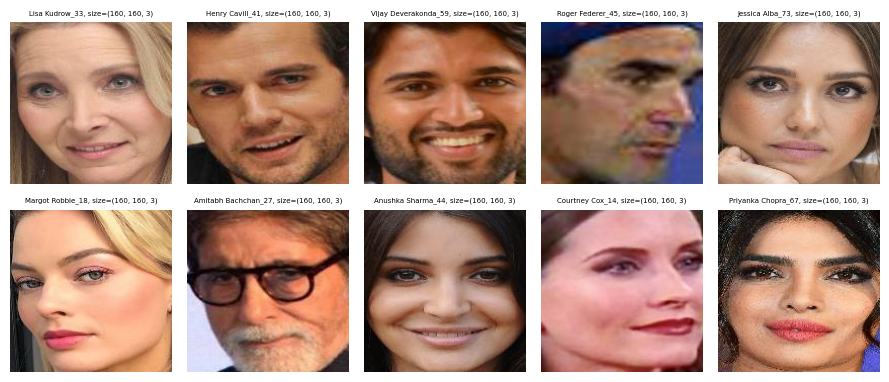

In [3]:
view_random_images(5,2, 'Faces')

In [4]:
list_of_files = os.listdir("Faces")
train_file_list, test_file_list = train_test_split(list_of_files, test_size=0.2, random_state=202)

Буду использовать в подготовке функцию для выравнивания лиц через landmarks, используемую на предыдущем задании

In [5]:
def align_face(image, landmarks):
    left_eye = landmarks[36:42].mean(axis=0)
    right_eye = landmarks[42:48].mean(axis=0)

    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dY, dX))

    eyes_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    rotation_matrix = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    aligned_image = cv2.warpAffine(
        image, rotation_matrix, (image.shape[1], image.shape[0])
    )

    return aligned_image

In [6]:
fa = face_alignment.FaceAlignment(
    face_alignment.LandmarksType.THREE_D,
    flip_input=False,
    device="cuda",
    dtype=torch.bfloat16,
    face_detector="blazeface",
    face_detector_kwargs={"back_model": True},
)

In [7]:
def prepare_data(path_to_data, file_list, img_size, face_alignment_model, augment = False):
    X,Y, label_list = [],[], []
    for filename in tqdm(file_list):
        full_path = join(path_to_data, filename)
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        label = filename.split(".")[0]
        label = label.split('_')[0]
        Y.append(label)
        label_list.append(label)
        try: 
            inp = io.imread(full_path)
            preds = face_alignment_model.get_landmarks(inp)[0]
            aligned_image = align_face(img, preds)
        except:
            aligned_image = img.copy()

        vector_img = img.reshape(aligned_image.shape[0] * aligned_image.shape[1])
        X.append(vector_img)
        if augment:
            img_flipped = cv2.flip(aligned_image, 1)
            vector_img_flipped = aligned_image.reshape(
                img_flipped.shape[0] * img_flipped.shape[1]
            )
            X.append(vector_img_flipped)
            Y.append(label)
            label_list.append(label)
    X = np.array(X)
    Y = np.array(Y)
    Y = np.unique(Y, return_inverse=True)[1]
    return X,Y

In [8]:
X_train, y_train = prepare_data('Faces',train_file_list, 160, fa, augment = True)
X_test, y_test = prepare_data("Faces", test_file_list, 160, fa)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_components = 200
pca = PCA(n_components=n_components, whiten=True, svd_solver="randomized")
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

  0%|          | 0/2049 [00:00<?, ?it/s]

c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\face_alignment\api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


  0%|          | 0/513 [00:00<?, ?it/s]

In [9]:
names = [
    "LogisticRegression",
    "Linear_SVM",
    "CatBoost",
    "Neural_Net",

]

classifiers = [
    LogisticRegression(),
    SVC(kernel="rbf"),
    CatBoostClassifier(verbose = False),
    MLPClassifier(alpha=1, max_iter=1000),
]

In [10]:
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
)

scores = pd.DataFrame()
for name, clf in tqdm(zip(names, classifiers)):

    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    new_row = {
        "Test": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred, average='macro'), 4),
        "Recall": round(recall_score(y_test, y_pred, average = 'macro'), 4),
        "F1 score": round(f1_score(y_test, y_pred, average='macro'), 4),
    }
    scores = pd.concat([scores, pd.DataFrame([new_row])])

scores = scores.set_index("Test")

display(scores)

0it [00:00, ?it/s]

,Accuracy,Precision,Recall,F1 score
Test,,,,
LogisticRegression,0.5361,0.5366,0.5309,0.5184
Linear_SVM,0.6140,0.6510,0.5828,0.5947
CatBoost,0.6140,0.6391,0.6058,0.6003
Neural_Net,0.5965,0.5994,0.5944,0.5852


Не самым лучшим образом справились классификаторы, лучшая точность у SVC: accuracy 61.40% vs 84.6% из библиотеки DeepFace. Посмотрим, удасться ли сделать лучше с помощью небольшой сети.

In [14]:
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import DataLoader

class PCAclassModel(pl.LightningModule):
    def __init__(self, num_epochs, input_features, output_features, learning_rate):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(in_features=64, out_features=output_features),
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # scheduler = torch.optim.lr_scheduler.StepLR(
        #     optimizer,
        #     step_size=7,
        #     gamma=0.3
        # )
        return [optimizer]

In [12]:
X_train_pca_tensors = torch.from_numpy(X_train_pca).type(torch.float)
y_train_tensors = torch.from_numpy(y_train).type(torch.int64)
X_test_pca_tensors = torch.from_numpy(X_test_pca).type(torch.float)
y_test_tensors = torch.from_numpy(y_test).type(torch.int64)

trainloader = DataLoader(
    [[X_train_pca_tensors[i], y_train_tensors[i]] for i in range(len(y_train))], shuffle=False, batch_size=8, drop_last=True
)
testloader = torch.utils.data.DataLoader(
    [[X_test_pca_tensors[i], y_test_tensors[i]] for i in range(len(y_test))],
    shuffle=False,
    batch_size=8,
)

In [15]:
num_epochs = 50
learning_rate = 0.001
input_features = n_components
output_features = len(
    list(set(np.unique(y_test).tolist() + np.unique(y_train).tolist()))
)
experiment_name = "PCA_face_recognitin"

wandb_logger = WandbLogger(project="wandb-lightning", name=experiment_name)
trainer = pl.Trainer(max_epochs=num_epochs, logger=wandb_logger)
model = PCAclassModel(num_epochs, input_features, output_features, learning_rate)
trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=testloader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 36.4 K | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.146     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▂▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇█████████
train_loss,█▇▆▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████▇█
val_loss,█▇▆▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_acc,0.6084
train_loss,1.3248
trainer/global_step,25599
val_acc,0.54776


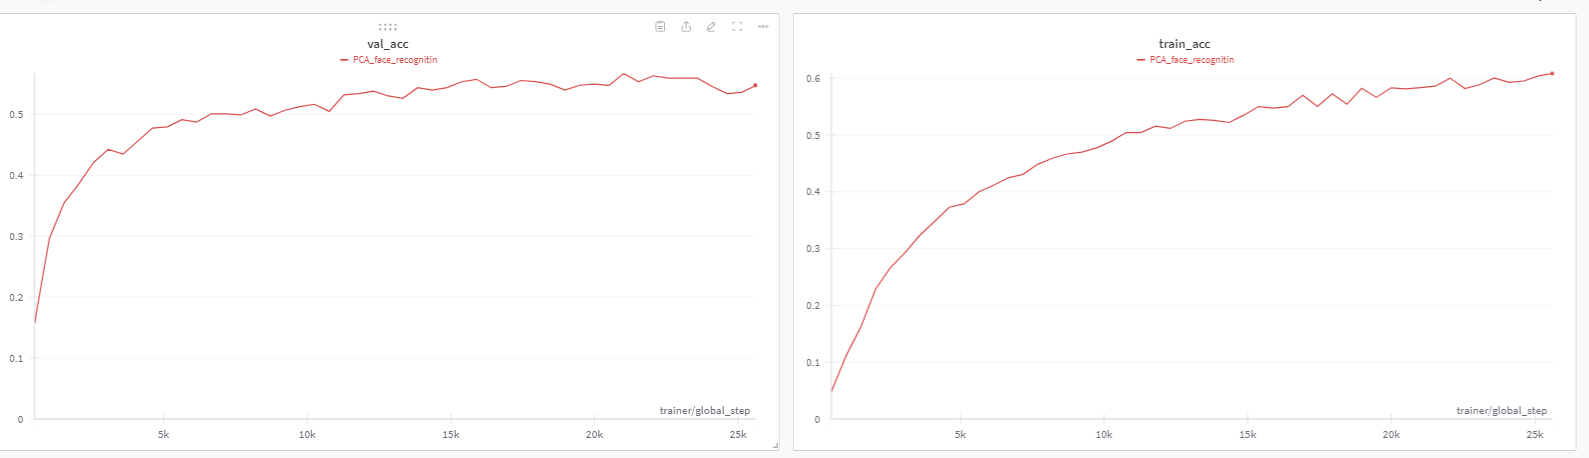

Результат получился хуже, чем от классического алгоритма максимальная accuracy 56.73% vs 84.6% от библиотеки DeepFace vs 61.40% от SVC.